### HEO Model : 1 Battery-1 Genset. 
=========================================================================================================================
$ 
\\
$

$ 
\\
$

### Optimization parameters.


$ Q_{\mathrm{max}} \hspace{1cm}$ : Maximal energy charge stored in battery (kWh).



$ Q_{\mathrm{init}} \hspace{1.1cm}$ : Initial energy charge stored in battery (kWh).



$ Q_{\mathrm{final}} \hspace{0.85cm}$ :  Final charge stored on battery (kWh).



$ P_{\mathrm{max}\;} \hspace{0.85cm}$ : Maximal power can be generated by genset (kW).



$ P_{\mathrm{min}\;} \hspace{0.9cm}$ : Minimal power can be generated by genset (kW).



${FC}_{max} \hspace{0.7cm}$ : Maximal fuel consumption (g).



$ {FC}_{offset} \hspace{0.4cm}$ : Offset for fuel consumption model (at P=0).



$ a \hspace{1.7cm}$ : Slope from fuel consumption model.



$ b \hspace{1.7cm}$ : Intercept from fuel consumption model.



$ \Delta t \hspace{1.5cm}$ : Time step in discretization (h).




$ t_{\mathrm{max}\;} \hspace{1.1cm}$ : Max time in simulation (h).



$ n \hspace{1.7cm}$ :  Number of time steps in simulation.



$ t_{\mathrm{max}\;} \hspace{1.1cm}$ : Max time in simulation (h).



$ t \hspace{1.8cm}$ :  Time vector in simulation (dim(t)=n).



$ \eta^{\mathrm{toBat}} \; \hspace{0.9cm}$ :  Efficiency when charging the battery.



$ \eta^{\mathrm{fromBat}} \; \hspace{0.5cm}$ :   Efficiency when producing from the battery.



$ L \hspace{1.6cm}$ : Vector of pre-defined load profile (must be of same length as time vector, dim(L)=dim(t)=n) (kW).

$\newline$ 


### Optimization model.

$\mathrm{minimize}\;\;\;\;\;\sum_{k=1}^n {FC}_{k\;} \cdot \frac{\Delta t}{1000}+K_{\mathrm{start}} \sum_{k=2}^n z_k$  

$\newline$ 

Fuel consumption model 1 (linear):     $\hspace{1cm} {FC}_{k\;} ={aP}_{k\;} +b-{FC}_{offset} \cdot \left(1-y_k \right)\hspace{3cm}$      $k=1,\dots ,n$

Load requirements:     $\hspace{3.5cm}L_k =P_k^{\mathrm{load}} +\eta {\;}^{\mathrm{fromBat}} {\cdot \;P}_k^{\mathrm{fromBat}}\hspace{4.2cm}$      $k=1,\dots ,n$  


Power split:   $\hspace{4.8cm}P_{k\;} =P_k^{\mathrm{load}} {+\;P}_k^{\mathrm{toBat}}\hspace{6.3cm}$   $k=1,\dots ,n$

Charge balance (initial):   $\hspace{2.8cm}Q_0 =Q_{\mathrm{init}}\hspace{6.3cm}$  

Charge balance:  $\hspace{4cm}Q_k =Q_{k-1} +\eta^{\mathrm{toBat}} \cdot \;P_k^{\mathrm{toBat}} \Delta t-\;P_k^{\mathrm{fromBat}} \Delta t\hspace{1.8cm}$     $k=1,\dots ,n$ 


Charge balance (final):     $\hspace{3cm}Q_n =Q_{\mathrm{final}}\hspace{3cm}$   


Logical conditions on genset: $\hspace{2cm}P_{k\;} \le {0\ldotp 9P}_{\mathrm{max}\;} {\cdot y}_k\hspace{6.7cm}$    $k=1,\dots ,n$ 


(0 or in 0.2P_max - 0.9Pmax):  $\hspace{2cm}P_{k\;} \le {0\ldotp 2P}_{\mathrm{max}\;} {\cdot y}_k\hspace{6.9cm}$    $k=1,\dots ,n$




Logical conditions on battery:   $\hspace{1.9cm}y_k^{\mathrm{toBat}} +y_{k\;}^{\mathrm{fromBat}} \le 1\hspace{6.4cm}$     $k=1,\dots ,n$  $ \\$     
$\hspace{6.9cm}P_k^{\mathrm{toBat}} \le 0\ldotp 9P_{\mathrm{max}} {\cdot y}_k^{\mathrm{toBat}}\hspace{5.7cm}$ $k=1,\dots ,n$ 


$\hspace{6.9cm}P_k^{\mathrm{fromBat}} \le 0\ldotp 9P_{\mathrm{max}} {\cdot \;y}_k^{\mathrm{fromBat}}\hspace{4.8cm}$  $k=1,\dots ,n$ 

$\newline$ 


Constraints for linearization of objective:  $\hspace{0.5cm}z_k \ge y_k -y_{k-1}\hspace{7.0cm}$ $k=2,\ldotp \ldotp \ldotp ,n$

$\newline$ 

Variable bounds:  $\hspace{4.1cm}0\ldotp 2Q_{\mathrm{max}} \le Q_k \le Q_{\mathrm{max}}\hspace{5.8cm}$ $k=0,\ldotp \ldotp \ldotp ,n$  $ \\$  
$\hspace{7cm}0\le P_k \le 0\ldotp 9P_{\mathrm{max}}\hspace{6.5cm}$  $k=1,\ldotp \ldotp \ldotp ,n$    
 
$\hspace{7cm}0\le P_k^{\mathrm{toBat}} ,P_k^{\mathrm{fromBat}} \le {0\ldotp 9P}_{\mathrm{max}}\hspace{4.2cm}$ $k=1,\ldotp \ldotp \ldotp ,n$ 


$\hspace{7cm}0\le z_k \le 1\hspace{7.8cm}$  $k=2,\ldotp \ldotp \ldotp ,n$


$ \\$ Variable types:     $\hspace{1cm}Q_k , P_k^{\mathrm{toBat}} , P_k^{\mathrm{fromBat}} ,Z_k$ :Continuous $\hspace{1cm}P_k$  :Semi-continuous  $\hspace{1.5cm}y_k ,y_k^{\mathrm{toBat}} ,y_k^{\mathrm{fromBat}}$ :Binary

$\newline$ 

$ \\$ $P_k \hspace{2.1cm} $:  Power from genset during time step k
 
$ \\$ $P_k^{\mathrm{toBat}}\hspace{1.5cm}$: Power to charge battery during time step k
 
$ \\$ $P_k^{\mathrm{fromBat}}\hspace{1.2cm}$: Power delivered from battery during time step k
 
$ \\$ $Q_k\hspace{2.1cm}$: Energy charge on battery at the end of time step k
 
$ \\$ $y_k\hspace{2.3cm}$: Variable equal to 1 if genset is used in time step k, variable equal to 0 if genset not used in time step k

$ \\$ $y_k^{\mathrm{toBat}}\hspace{1.6cm}$: Variable equal to 1 if battery is charged under time step k

$ \\$ $y_k^{\mathrm{fromBat}}\hspace{1.3cm}$: Variable equal to 1 if battery if used for load in time step k

$ \\$ $z_k\hspace{2.3cm}$: Variable used to linearize additional cost when starting genset (  )



$\newline $
$\newline $




$\newline $
### Importing modules.

In [61]:
import sys
import numpy as np
import plotly.express as px
from IPython.display import Image
import pandas as pd
from pulp import *
from src.functions.fuel_consumption import fuelCon
from src.functions.load_window import lwd 

### Python environment.

In [62]:
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


$\newline $
### Introducing problem Parameters.

In [63]:
Q_max = 250                                                   # maximal capacity stored on battery.
Q_0 = 0.5*Q_max                                               # inital capacity stored on battery.
Q_final = 0.5*Q_max                                           # Final capacity stored on the battery. 
eff_to_bat = 0.98                                             # battery charging efficiency.
eff_from_bat = 0.98                                           # battery transfer efficiency. 
P_max = 1000                                                  # max output from gen set A.
P_min = 0                                                     # min output from gen set A.        
dt = 1                                                        # simulation time step dt.
t_max = 10                                                    # time span for simulation = t_max hours.
t = np.atleast_2d(np.arange(0,t_max,dt)).T.conj()             # time scale in hours.
n = len(t)                                                    # number of time steps.
m = 1                                                         # number of Gensets used on the trip.
fc_offset = 190                                               # genset j fuel consumption when no power gnerated (p=0) in g/h.
V_steps = [x for x in range(0,n)]                             # Time steps vector. 
V_steps_z = V_steps[:-1]                                      # Time steps vector without the final step. 


L = lwd (200,50,5,                                           # Power requirement window.
                50,300,5,
                200,150,10,
                150,250,30,
                0,5,20,30)                                   # Pre-defined load porfile requirements framed in 60 time steps.

$\newline $
### Creating the problem variable. 

In [64]:
Optim = LpProblem('Energy_Opt',LpMinimize)

$\newline $
### Slope, intercept and maximum fuel bound calculation.

In [65]:
a_j = (fuelCon(0.9*P_max, P_max) - fuelCon(0.2*P_max, P_max)) /(0.9*P_max) #slope.
b_j = fuelCon(0.2*P_max, P_max) - a_j*0.2*P_max #Intercept.
maxFC = fuelCon(0.9*P_max,P_max) # Max fuel bound.
print('FC Linear model caracteristics')
print('-----------------------------')
print('Slope =', a_j)
print('Intercept =', b_j)

FC Linear model caracteristics
-----------------------------
Slope = 144.9
Intercept = 20339.999999999996


$\newline $
### Setting-up decision Variables.

In [66]:
Q_bat = LpVariable.dicts("Q_bat", V_steps, lowBound=0.2*Q_max, upBound=Q_max, cat = LpContinuous)  # Battery charge at time step k.
P_From_bat = LpVariable.dicts("P_From_bat", V_steps, lowBound=P_min, upBound=0.9*P_max, cat = LpContinuous) # Power transfered from the battery to the load.
P = LpVariable.dicts("P", V_steps, lowBound=P_min, upBound=0.9*P_max, cat = LpContinuous)  # Power generated by the Genset A.
P_load = LpVariable.dicts("P_load", V_steps, lowBound=P_min, upBound=0.9*P_max, cat= LpContinuous) # Power transfered from the Genset A to the load at time step k.
Z =  LpVariable.dicts("Z", V_steps_z, lowBound=0, upBound=1, cat = LpInteger) # Aditional cost fuel oil consumption when starting Genset j.
FOC = LpVariable.dicts("FOC", V_steps, lowBound=0, upBound= maxFC, cat = LpContinuous) # Fuel oil consumption of genset j.
P_to_bat =  LpVariable.dicts("P_to_bat", V_steps, lowBound=P_min, upBound=0.9*P_max, cat = LpContinuous) 
Y_to_bat = LpVariable.dicts("Y_to_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter to charge the battery at time step k. 
Y_from_bat = LpVariable.dicts("Y_from_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Battery selecter to transfert to the Genset j st time step k.
Y = LpVariable.dicts("Y", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter : work ==> Y=1, Not work ==> Y=0.

$\newline $
### Setting-up the objective function.

In [67]:
FC = sum(FOC[k] for k in V_steps) * dt/1000  # sum of the fuel oil comsumption for all gensets over all k steps.
L_added_cost = sum(Z[i] for i in V_steps_z)  # Sum of all of the additional costs including starting costs. 
Optim += lpSum (FC + L_added_cost), " Minimization fuel oil consumption objective " 
print(FC)

0.001*FOC_0 + 0.001*FOC_1 + 0.001*FOC_2 + 0.001*FOC_3 + 0.001*FOC_4 + 0.001*FOC_5 + 0.001*FOC_6 + 0.001*FOC_7 + 0.001*FOC_8 + 0.001*FOC_9


$\newline $
$\newline $
### Setting-up problem constraints.

In [68]:

for k in V_steps:

  # Fuel oil consumption constraint.
  Optim += FOC[k] == P[k]*a_j + b_j - fc_offset*Y[k]     

  # Load requirements constraints
  Optim += P_load[k] + eff_from_bat*P_From_bat[k] == L[k]       
  Optim += P_load[k] + P_to_bat[k] == P[k]                  


  # Genset logical constraints.
  Optim += P[k]  <= 0.9 * P_max * Y[k]
  Optim += P[k]  >= 0.2 * P_max * Y[k]
    
  # Battery charging logical constraints.
  Optim += P_to_bat[k] <= 0.9 * P_max * Y_to_bat[k]
  Optim += P_From_bat[k] <= 0.9 * P_max * Y_from_bat[k]
  Optim += Y_to_bat[k] + Y_from_bat[k]  <= 1
  

  # Charge balance logical constraints.
  if k == V_steps[0] :                                            
    Optim += Q_bat[k] == Q_0 + eff_to_bat*P_to_bat[k]*dt - P_From_bat[k]*dt


  else :  
    Optim += Q_bat[k] == Q_bat[k-1] + eff_to_bat*P_to_bat[k]*dt - P_From_bat[k]*dt

    
# Additional starting costs constraint.
for k in range(V_steps[0], V_steps[-1]): 
  Optim += Z[k] >= Y[k + 1] - Y[k] 
  
# Charge balance at the Final time step.
Optim += Q_bat[V_steps[-1]] == Q_final

$\newline $
$\newline $
### Solving the problem.

In [69]:
status = Optim.solve(GUROBI())

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i3-4000M CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 100 rows, 99 columns and 247 nonzeros
Model fingerprint: 0xc6d66fdd
Variable types: 60 continuous, 39 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+02]
  Objective range  [1e-03, 1e+00]
  Bounds range     [1e+00, 2e+05]
  RHS range        [1e+00, 2e+04]
Presolve removed 80 rows and 77 columns
Presolve time: 0.01s
Presolved: 20 rows, 22 columns, 62 nonzeros
Variable types: 12 continuous, 10 integer (10 binary)
Found heuristic solution: objective 421.7466380

Root relaxation: objective 4.216701e+02, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  421.67008    0   

$\newline $
$\newline $
### Printing optimization status.

In [70]:
LpStatus[status]

'Optimal'

$\newline $
$\newline $
### Printing constraints per each time step.

In [71]:
print(Optim.variables)

<bound method LpProblem.variables of Energy_Opt:
MINIMIZE
0.001*FOC_0 + 0.001*FOC_1 + 0.001*FOC_2 + 0.001*FOC_3 + 0.001*FOC_4 + 0.001*FOC_5 + 0.001*FOC_6 + 0.001*FOC_7 + 0.001*FOC_8 + 0.001*FOC_9 + 1*Z_0 + 1*Z_1 + 1*Z_2 + 1*Z_3 + 1*Z_4 + 1*Z_5 + 1*Z_6 + 1*Z_7 + 1*Z_8 + 0.0
SUBJECT TO
_C1: FOC_0 - 144.9 P_0 + 190 Y_0 = 20340

_C2: 0.98 P_From_bat_0 + P_load_0 = 200

_C3: - P_0 + P_load_0 + P_to_bat_0 = 0

_C4: P_0 - 900 Y_0 <= 0

_C5: P_0 - 200 Y_0 >= 0

_C6: P_to_bat_0 - 900 Y_to_bat_0 <= 0

_C7: P_From_bat_0 - 900 Y_from_bat_0 <= 0

_C8: Y_from_bat_0 + Y_to_bat_0 <= 1

_C9: P_From_bat_0 - 0.98 P_to_bat_0 + Q_bat_0 = 125

_C10: FOC_1 - 144.9 P_1 + 190 Y_1 = 20340

_C11: 0.98 P_From_bat_1 + P_load_1 = 162.5

_C12: - P_1 + P_load_1 + P_to_bat_1 = 0

_C13: P_1 - 900 Y_1 <= 0

_C14: P_1 - 200 Y_1 >= 0

_C15: P_to_bat_1 - 900 Y_to_bat_1 <= 0

_C16: P_From_bat_1 - 900 Y_from_bat_1 <= 0

_C17: Y_from_bat_1 + Y_to_bat_1 <= 1

_C18: P_From_bat_1 - 0.98 P_to_bat_1 - Q_bat_0 + Q_bat_1 = 0

_C19: 

In [72]:
for v in Optim.variables():
    print(v.name, "=", v.varValue )

FOC_0 = 49129.999957236294
FOC_1 = 49129.99999999999
FOC_2 = 50028.458497574145
FOC_3 = 20340.00000000003
FOC_4 = 20340.000000000015
FOC_5 = 20340.000000000004
FOC_6 = 49130.0
FOC_7 = 49129.99999999997
FOC_8 = 54563.75
FOC_9 = 58614.42950000003
P_0 = 199.99999970487437
P_1 = 199.99999999999997
P_2 = 206.20054173619152
P_3 = 2.2737367544323206e-13
P_4 = 1.1368683772161603e-13
P_5 = 4.263256414560601e-14
P_6 = 200.0
P_7 = 199.9999999999998
P_8 = 237.5
P_9 = 265.4550000000002
P_From_bat_0 = 0.0
P_From_bat_1 = 0.0
P_From_bat_2 = 0.0
P_From_bat_3 = 89.28571428571429
P_From_bat_4 = 51.02040816326531
P_From_bat_5 = 51.02040816326531
P_From_bat_6 = 0.0
P_From_bat_7 = 0.0
P_From_bat_8 = 0.0
P_From_bat_9 = 35.24999999999977
P_load_0 = 200.0
P_load_1 = 162.5
P_load_2 = 125.0
P_load_3 = 0.0
P_load_4 = 0.0
P_load_5 = 0.0
P_load_6 = 112.5
P_load_7 = 175.0
P_load_8 = 237.5
P_load_9 = 265.4550000000002
P_to_bat_0 = -2.917922972671901e-07
P_to_bat_1 = 37.49999999999997
P_to_bat_2 = 81.20054173619152
P_

$\newline $
$\newline $
### Calculating the optimized fuel comsumption.

In [73]:
print("Total fuel comsumption of the trip:", value(Optim.objective),'g') 

Total fuel comsumption of the trip: 421.74663795481047 g


$\newline $
### Pre-processing visualisation data.

In [74]:
# Constructing list out of the P_A vector.

P_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_'+ str(i)):
      P_list.append(v.varValue)
print(P_list)

# Constructing list out of the P_A_load vector.

P_load_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_load_'+ str(i)):
      P_load_list.append(v.varValue)
print(P_load_list)

# Constructing list out of the P_A_to_bat vector.

P_to_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_to_bat_'+ str(i)):
      P_to_bat_list.append(v.varValue)
print(P_to_bat_list)

# Constructing list out of the P_From_bat.

P_From_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_From_bat_'+ str(i)):
      P_From_bat_list.append(v.varValue)
print(P_From_bat_list)

# Constructing list out of the Q_bat vector.

Q_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('Q_bat_'+ str(i)):
      Q_bat_list.append(v.varValue)
print(Q_bat_list)

# constructing list out of the FC_A vector.

FOC_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('FOC_'+ str(i)):
      FOC_list.append(v.varValue/1000)
print(FOC_list)

# Constructing list out of load profil vector.

d_load_list = []              
for i in V_steps:
    d_load_list.append(L[i])
print(d_load_list)



[199.99999970487437, 199.99999999999997, 206.20054173619152, 2.2737367544323206e-13, 1.1368683772161603e-13, 4.263256414560601e-14, 200.0, 199.9999999999998, 237.5, 265.4550000000002]
[200.0, 162.5, 125.0, 0.0, 0.0, 0.0, 112.5, 175.0, 237.5, 265.4550000000002]
[-2.917922972671901e-07, 37.49999999999997, 81.20054173619152, 2.2737367544323206e-13, 1.1368683772161603e-13, 4.263256414560601e-14, 87.50000000000001, 24.9999999999998, 0.0, 0.0]
[0.0, 0.0, 0.0, 89.28571428571429, 51.02040816326531, 51.02040816326531, 0.0, 0.0, 0.0, 35.24999999999977]
[124.99999971077689, 161.74999971077688, 241.32653061224454, 152.04081632653046, 101.02040816326527, 50.0, 135.75, 160.24999999999977, 160.24999999999977, 125.0]
[49.12999995723629, 49.129999999999995, 50.02845849757414, 20.34000000000003, 20.340000000000014, 20.340000000000003, 49.13, 49.129999999999974, 54.56375, 58.61442950000003]
[200.0, 162.5, 125.0, 87.5, 50.0, 50.0, 112.5, 175.0, 237.5, 300.0]


$\newline $

### Load requirement window. 

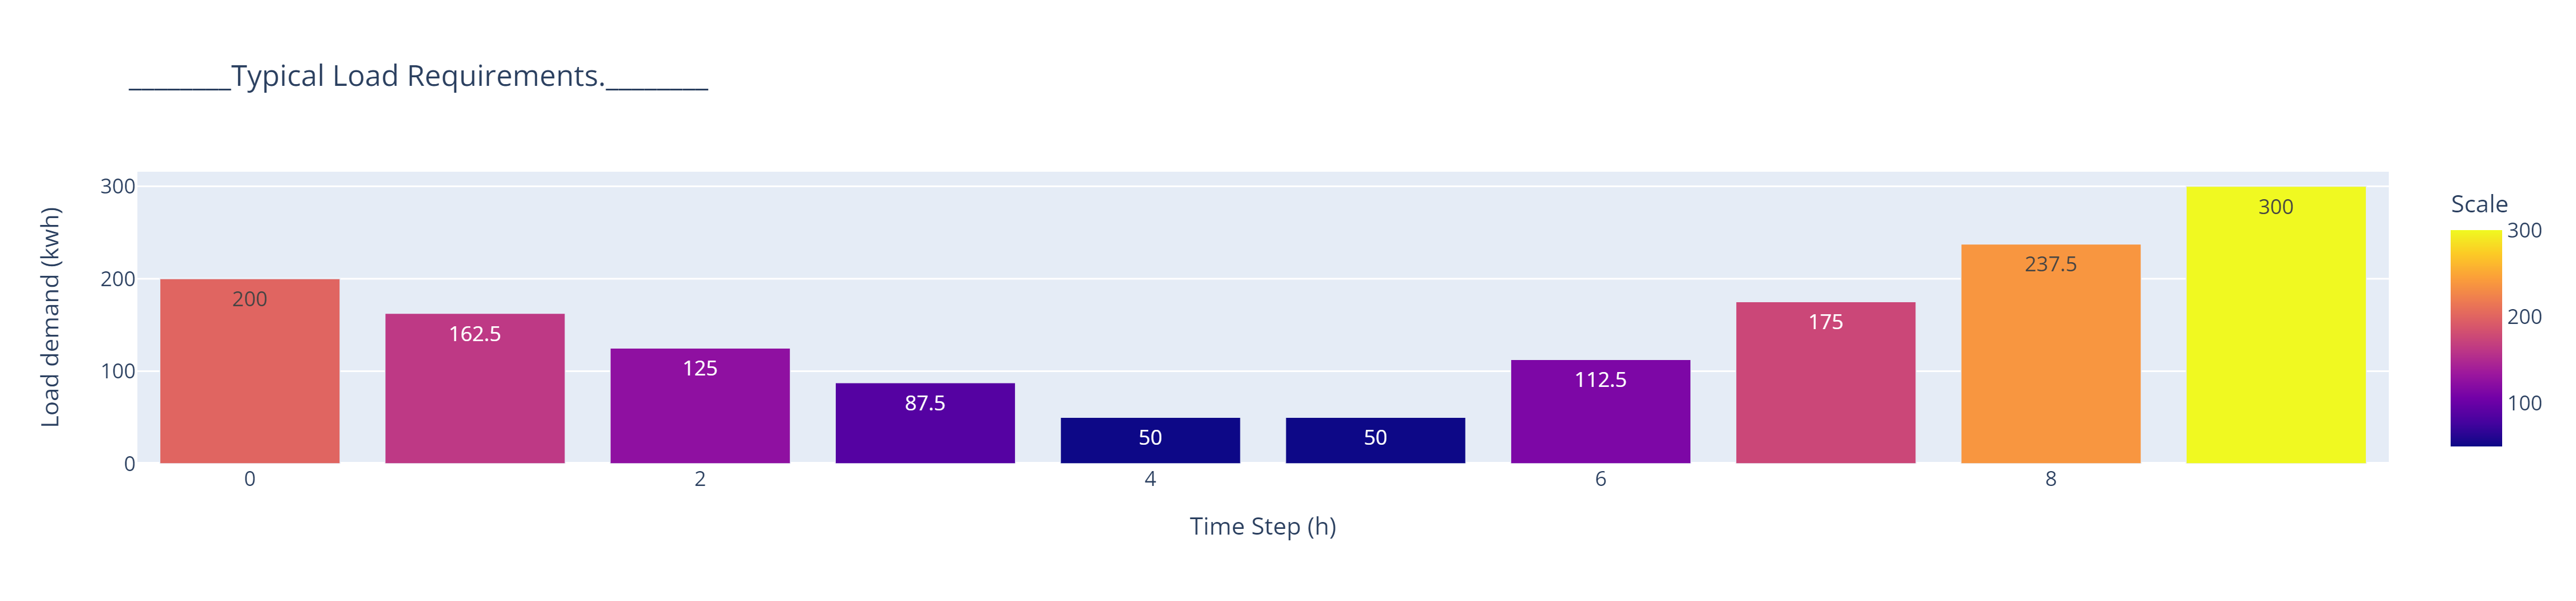

In [75]:
L_dframe = {
             'Load requirement.': d_load_list,
             'Scale' : d_load_list}

L_df = pd.DataFrame(L_dframe)
fig = px.bar(L_df, x = V_steps,
             y = d_load_list,
             title = '________Typical Load Requirements.________',
             height = 400,
             width = 1350,
             labels = dict(x= "Time Step (h)", y = "Load demand (kwh)"), text_auto = True, color = 'Scale')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [76]:
print(V_steps,L)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] {0: 200.0, 1: 162.5, 2: 125.0, 3: 87.5, 4: 50.0, 5: 50.0, 6: 112.5, 7: 175.0, 8: 237.5, 9: 300.0, 20: 200.0, 21: 194.44444444444446, 22: 188.88888888888889, 23: 183.33333333333334, 24: 177.77777777777777, 25: 172.22222222222223, 26: 166.66666666666669, 27: 161.11111111111111, 28: 155.55555555555554, 29: 150.0, 30: 150.0, 31: 153.44827586206895, 32: 156.89655172413794, 33: 160.3448275862069, 34: 163.79310344827587, 35: 167.24137931034483, 36: 170.68965517241378, 37: 174.13793103448276, 38: 177.58620689655172, 39: 181.0344827586207, 40: 184.48275862068965, 41: 187.9310344827586, 42: 191.3793103448276, 43: 194.82758620689654, 44: 198.27586206896552, 45: 201.72413793103448, 46: 205.17241379310343, 47: 208.6206896551724, 48: 212.06896551724137, 49: 215.51724137931035, 50: 218.9655172413793, 51: 222.41379310344826, 52: 225.86206896551724, 53: 229.31034482758622, 54: 232.75862068965517, 55: 236.20689655172413, 56: 239.65517241379308, 57: 243.10344827586206, 58: 

$\newline $
### Generated genset power.

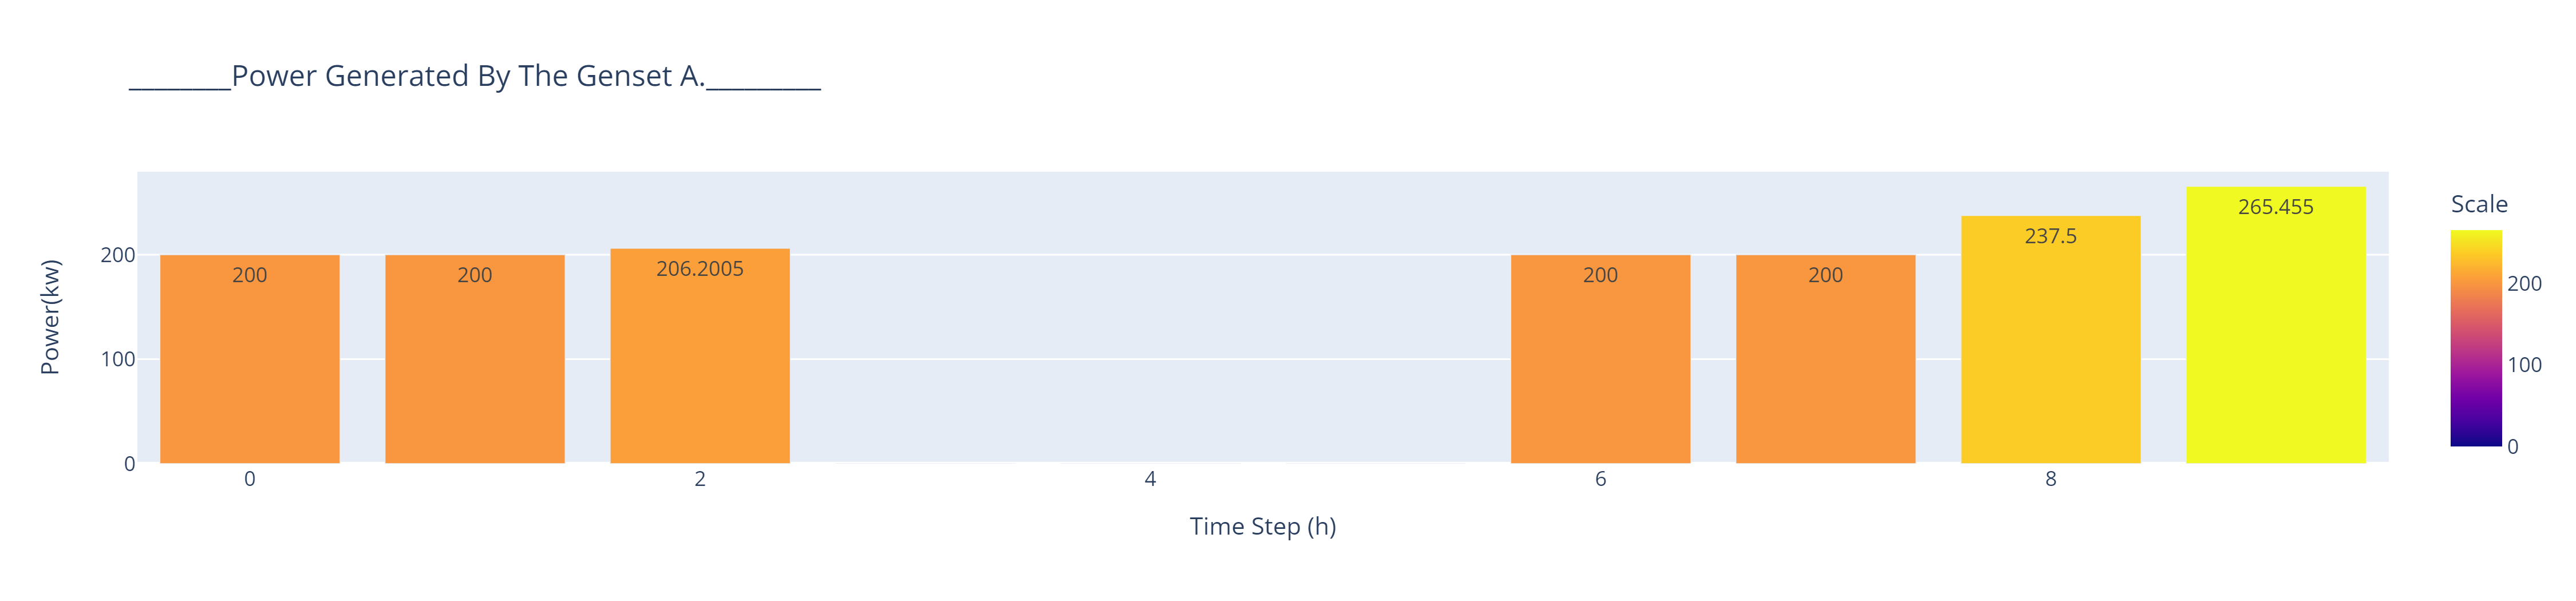

In [77]:
P_A_dframe = {
             'Power generated by the Genset.': P_list,
             'Scale' : P_list}

P_A_df = pd.DataFrame(P_A_dframe)
fig = px.bar(P_A_df, x = V_steps,
             y = P_list,
             title = '________Power Generated By The Genset A._________',
             height = 400,
             width = 1350,
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True, color = 'Scale')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [78]:
print(V_steps, P_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [199.99999970487437, 199.99999999999997, 206.20054173619152, 2.2737367544323206e-13, 1.1368683772161603e-13, 4.263256414560601e-14, 200.0, 199.9999999999998, 237.5, 265.4550000000002]


$\newline $
### Realised power from the genset to load.

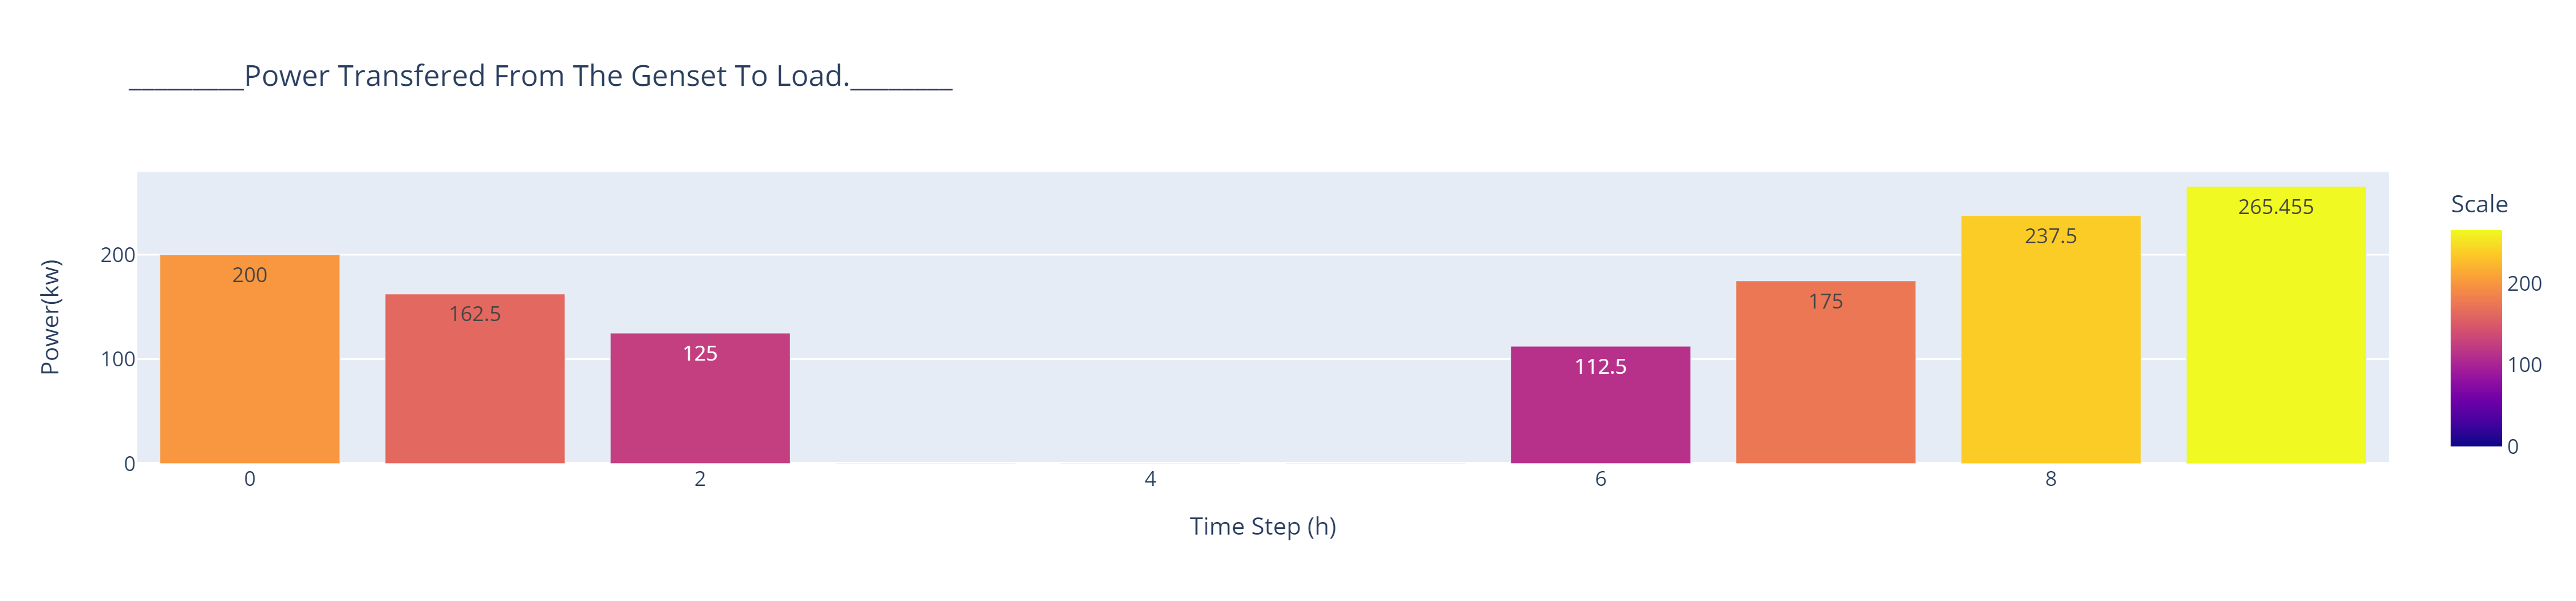

In [79]:
P_to_load_dframe = {
             "Power from Genset to laod.": P_load_list,
             'Scale' : P_load_list}

P_to_load_df = pd.DataFrame(P_to_load_dframe)


fig = px.bar(P_to_load_df, x = V_steps,
             y = P_load_list,
             title = '_________Power Transfered From The Genset To Load.________',
             height = 400,
             width = 1350,
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True, color = 'Scale')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [80]:
print(V_steps, P_load_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [200.0, 162.5, 125.0, 0.0, 0.0, 0.0, 112.5, 175.0, 237.5, 265.4550000000002]


$\newline $
### Realised power to charge the battery.

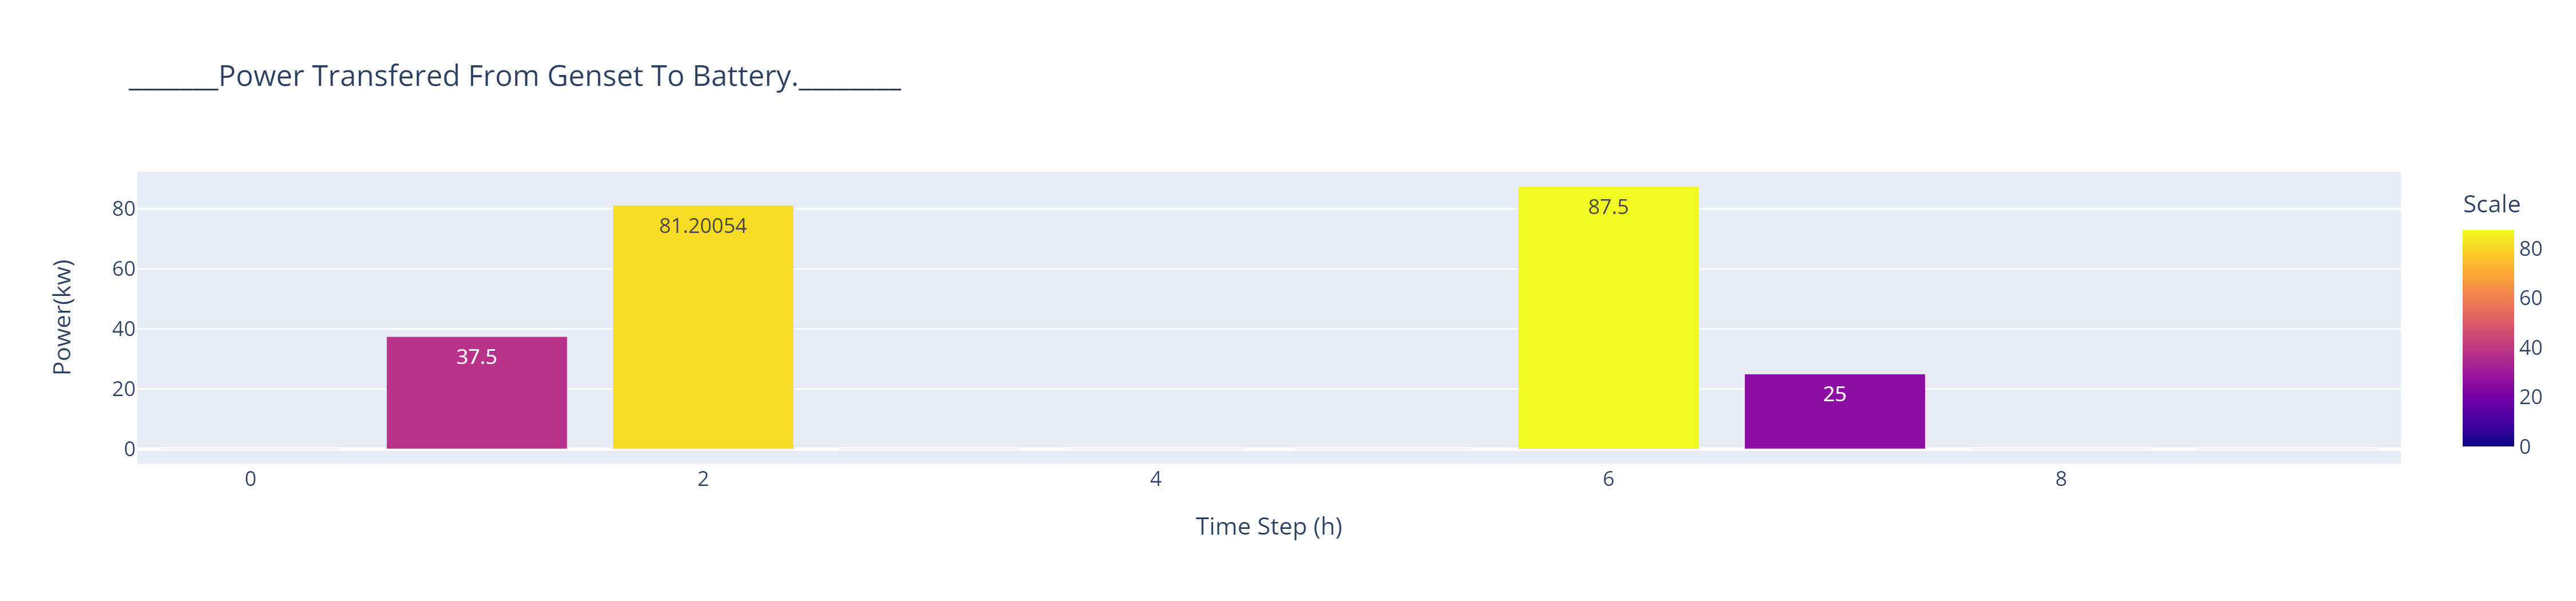

In [81]:
P_to_bat_dframe = {
             "Power from Genset to battery.": P_to_bat_list,
             'Scale' : P_to_bat_list}

P_to_bat_df = pd.DataFrame(P_to_bat_dframe)

fig = px.bar(P_to_bat_df, x = V_steps,
             y = P_to_bat_list,
             title = '_______Power Transfered From Genset To Battery.________',
             height = 400,
             width = 1350,
             labels = dict(x = "Time Step (h)", y = "Power(kw)", ), text_auto = True, color = 'Scale')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [82]:
print(V_steps, P_to_bat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [-2.917922972671901e-07, 37.49999999999997, 81.20054173619152, 2.2737367544323206e-13, 1.1368683772161603e-13, 4.263256414560601e-14, 87.50000000000001, 24.9999999999998, 0.0, 0.0]


$\newline $
### Realised power from the battery to load.

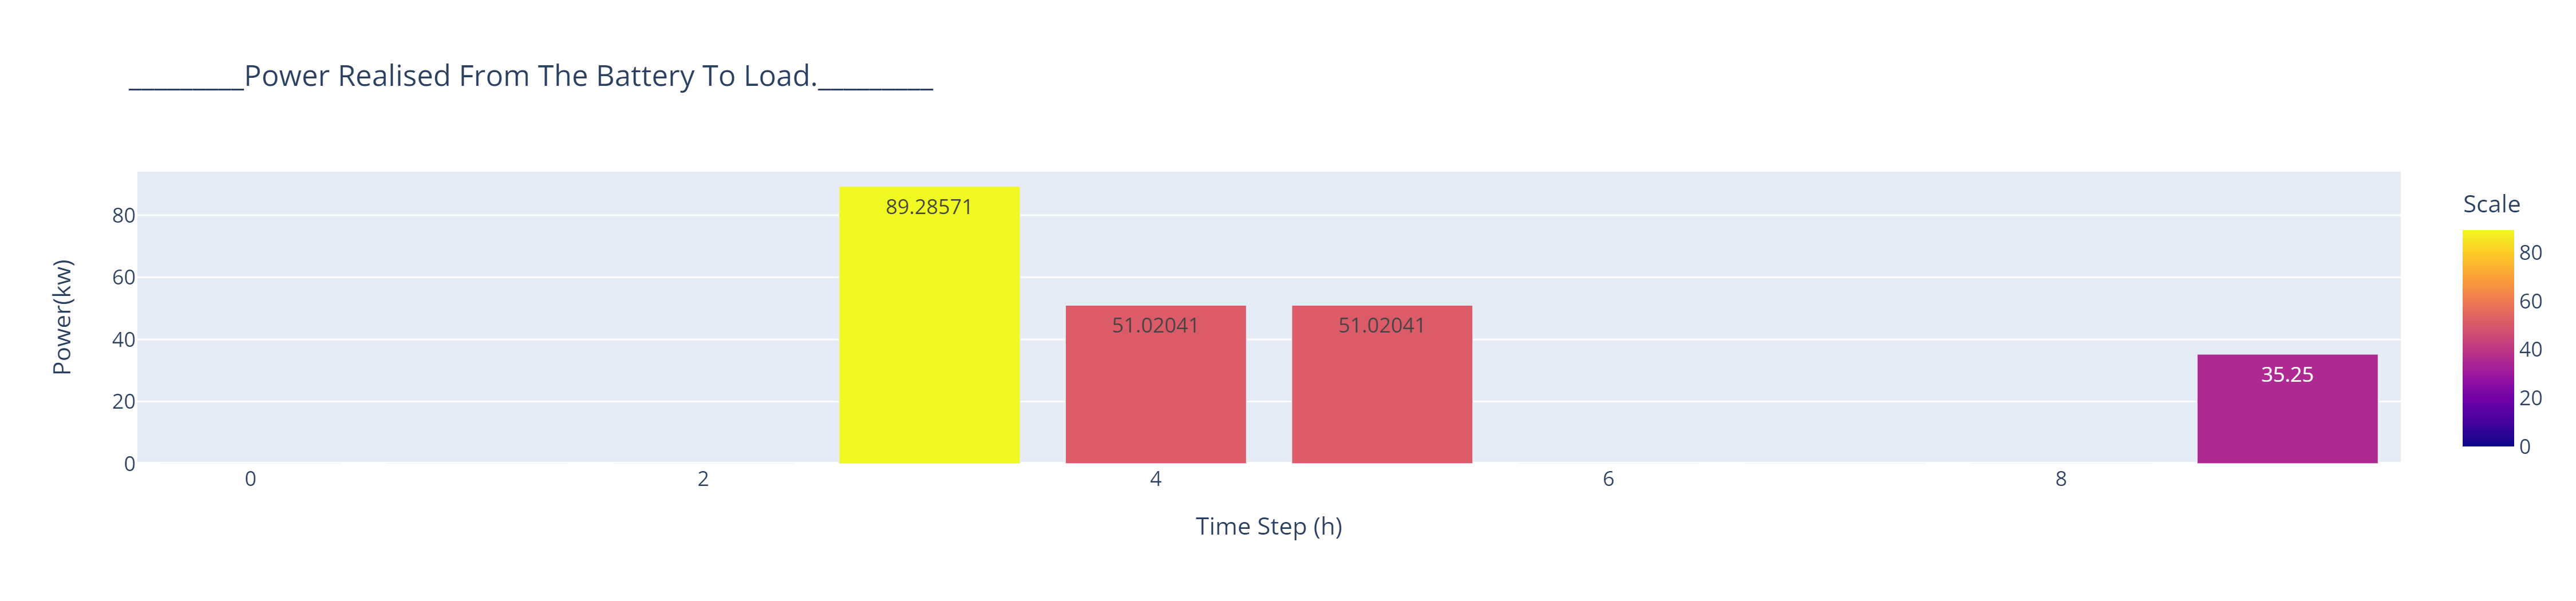

In [83]:
P_From_bat_dframe = {
             "Power from the battery to load.": P_From_bat_list,
             'Scale' : P_From_bat_list}

P_From_df = pd.DataFrame(P_From_bat_dframe)

fig = px.bar(P_From_df, x = V_steps,
             y = P_From_bat_list,
             title = '_________Power Realised From The Battery To Load._________',
             height = 400,
             width = 1350,
             labels = dict(x = "Time Step (h)", y = "Power(kw)"), text_auto = True, color = 'Scale')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [84]:
print(V_steps, P_From_bat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [0.0, 0.0, 0.0, 89.28571428571429, 51.02040816326531, 51.02040816326531, 0.0, 0.0, 0.0, 35.24999999999977]


### Battery charge balance.

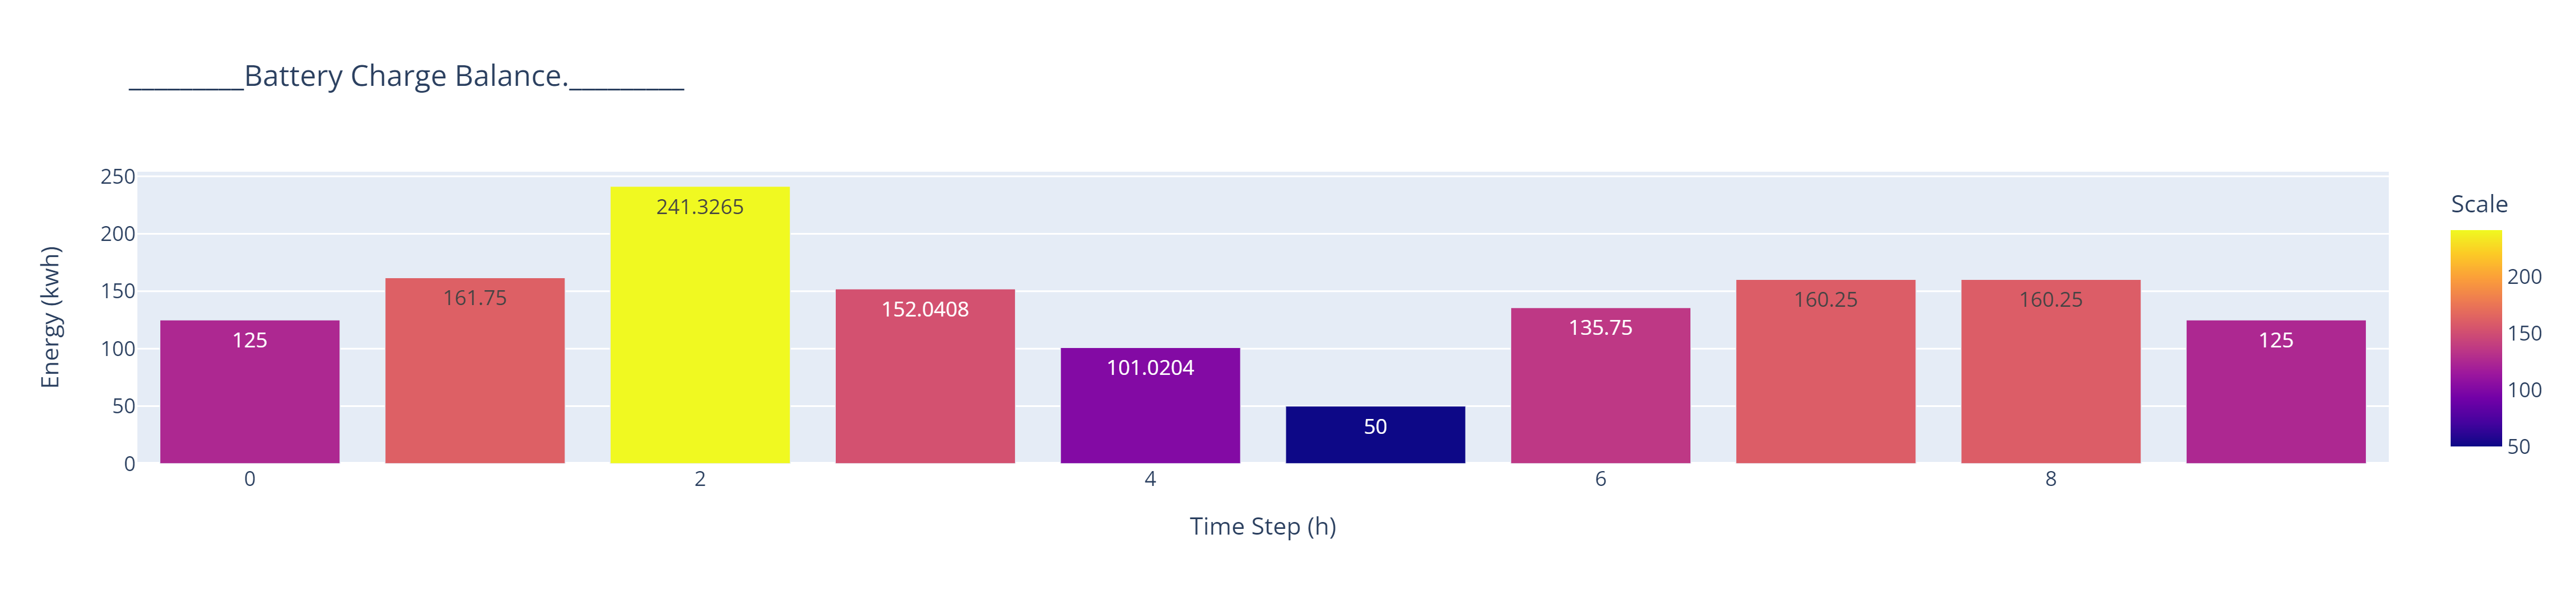

In [85]:
Q_bat_dframe = {
             'Battery charge balance.': Q_bat_list,
             'Scale' : Q_bat_list}

Q_bat_df = pd.DataFrame(Q_bat_dframe)


fig = px.bar(Q_bat_df, x = V_steps,
             y = Q_bat_list,
             title = '_________Battery Charge Balance._________',
             height = 400,
             width = 1350,
             labels = dict(x = "Time Step (h)", y = "Energy (kwh)"), text_auto = True, color = 'Scale')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [86]:
print(V_steps, Q_bat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [124.99999971077689, 161.74999971077688, 241.32653061224454, 152.04081632653046, 101.02040816326527, 50.0, 135.75, 160.24999999999977, 160.24999999999977, 125.0]


$\newline $
### Genset fuel consumption.

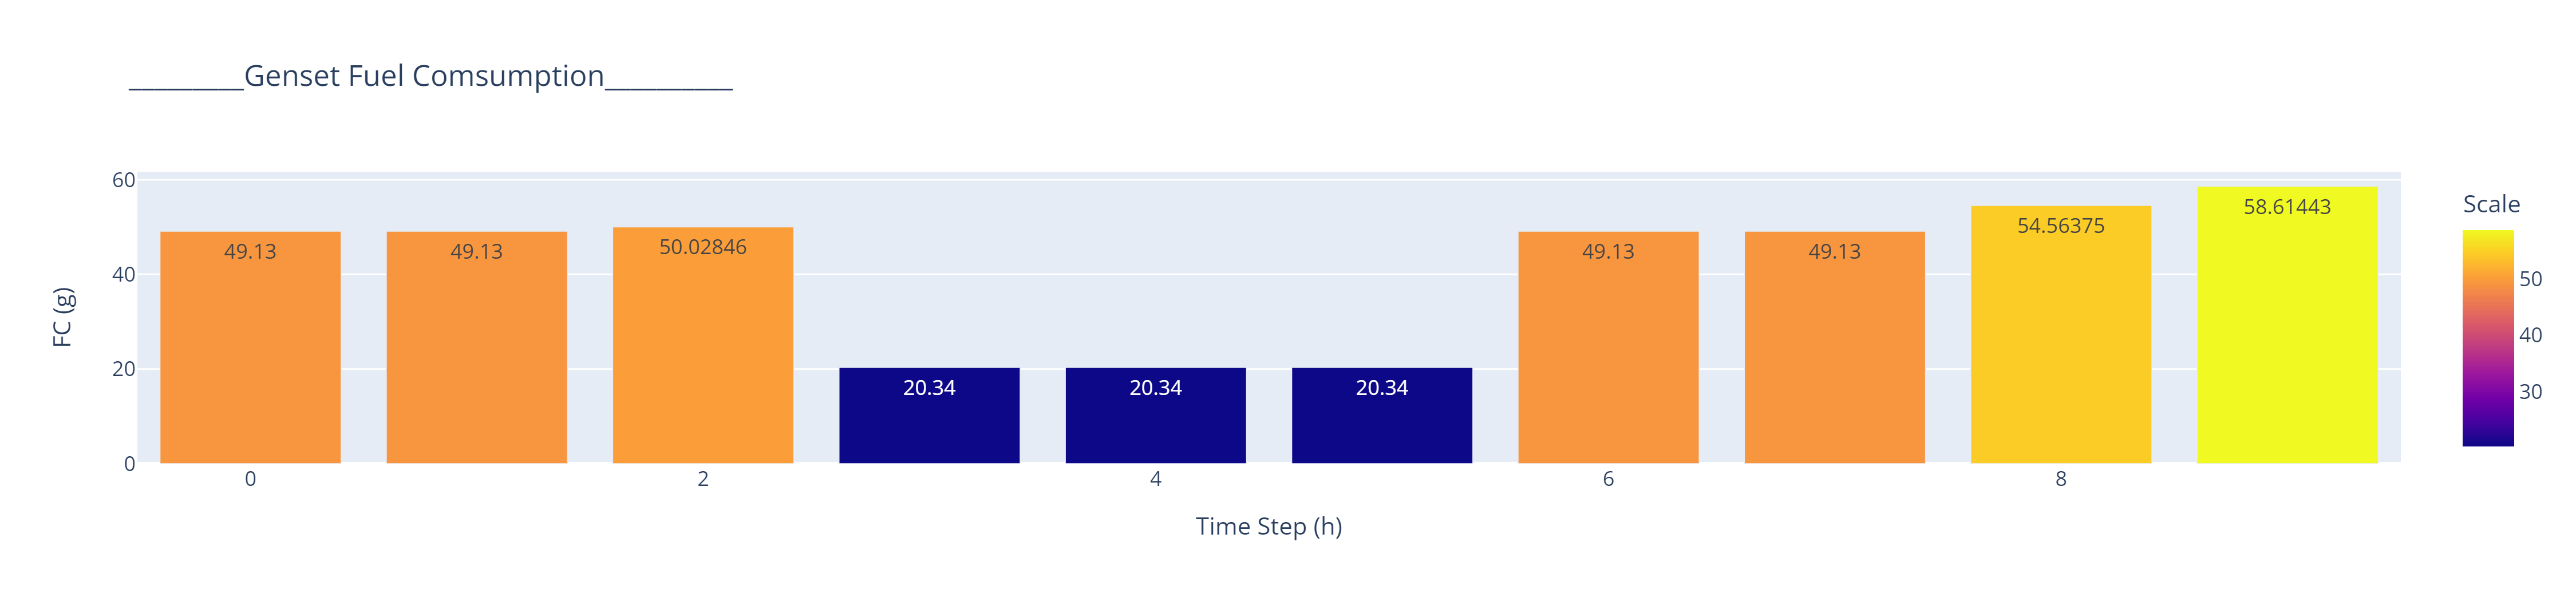

In [87]:
fc_dframe = {
             'Fuel consumption of the Genset.': FOC_list,
             'Scale' : FOC_list}

fc_df = pd.DataFrame(fc_dframe)
fig = px.bar(fc_df, x = V_steps,
             y = FOC_list,
             title = "_________Genset Fuel Comsumption__________",
             height = 400, width = 1350,
             labels = dict(x = "Time Step (h)", y = "FC (g)"), text_auto = True, color = 'Scale',)
#fig.write_image('P_A_list.svg')
Image(fig.to_image(format='png', width=1500, height=350, scale=3))

In [88]:
print(V_steps, FOC_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [49.12999995723629, 49.129999999999995, 50.02845849757414, 20.34000000000003, 20.340000000000014, 20.340000000000003, 49.13, 49.129999999999974, 54.56375, 58.61442950000003]


In [89]:
print(sum(FOC_list)*dt)

420.74663795481047


$\newline $
$\newline $
### Trip power flow bar chart.

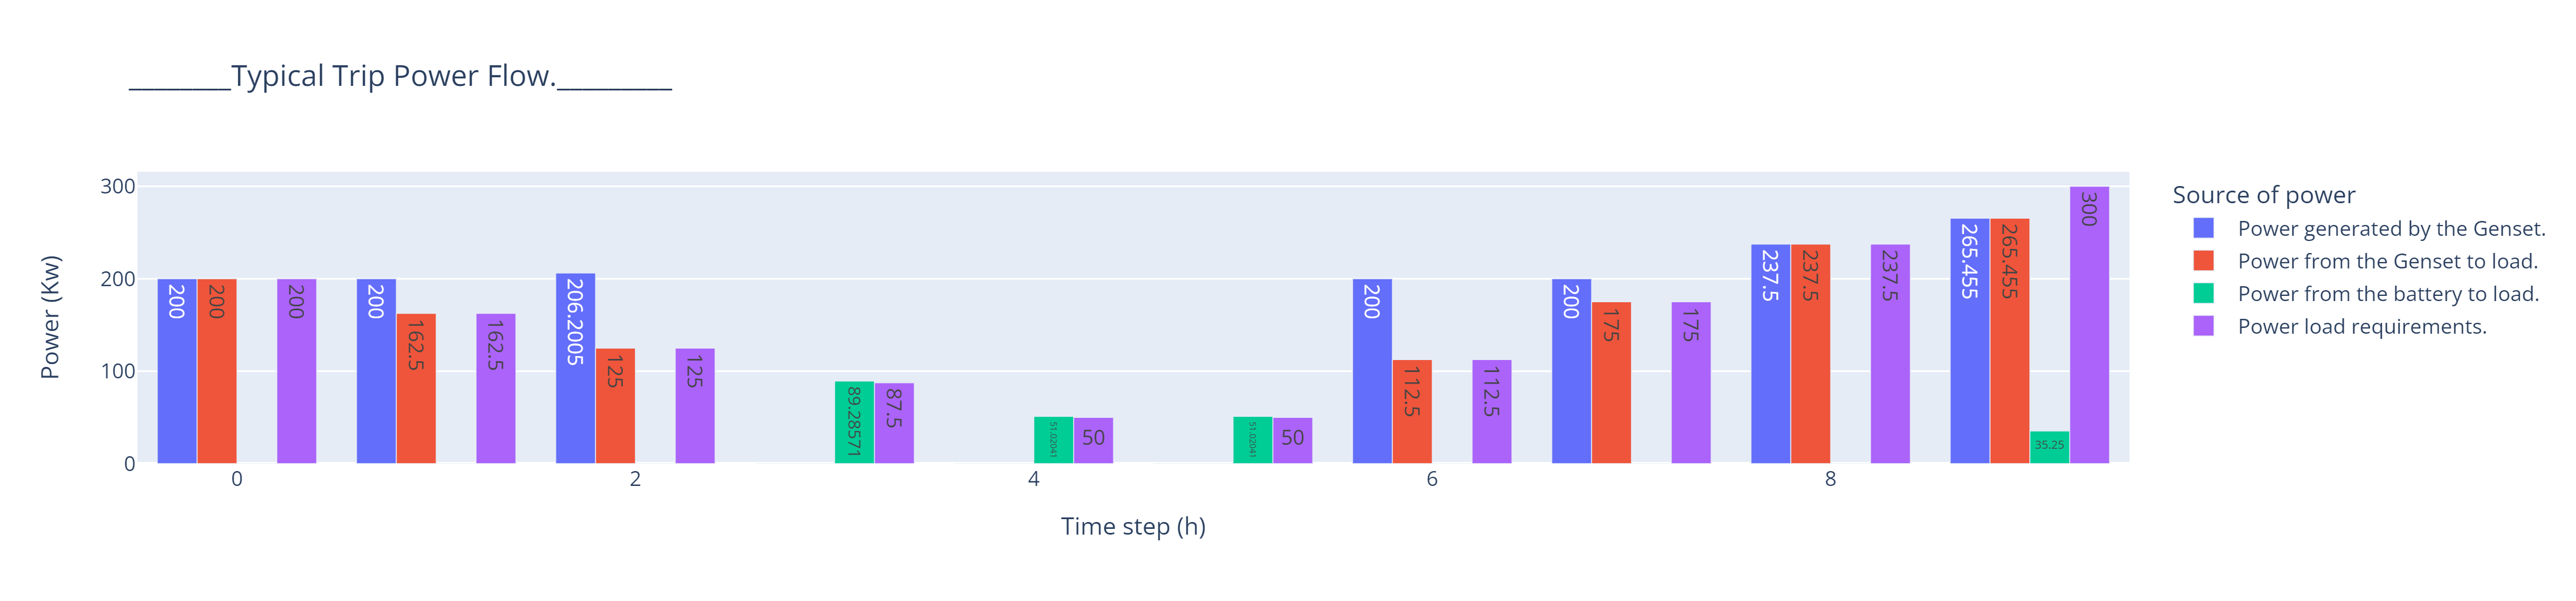

In [90]:
dictframe = {
             'Power generated by the Genset.': P_list,
             "Power from the Genset to load.": P_load_list,
             "Power from the battery to load.": P_From_bat_list,
             "Power load requirements.": d_load_list
               }

df = pd.DataFrame(dictframe)
fig = px.bar(df, x = V_steps,
             y = df.columns,
             barmode = 'group',
             width = 1500,
             text_auto = True,
             title = '________Typical Trip Power Flow._________',
             labels = {'x':'Time step (h)',
                      'value': 'Power (Kw)',
                      'variable': 'Source of power'})
Image(fig.to_image(format='png', width=1500, height=350, scale=3))